In [2]:
import matplotlib.pyplot as plt
import numpy as np                              
from scipy.integrate import solve_ivp 
from scipy.stats import norm      
import numpy as numpy

In [3]:
import warnings
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt                                       
from scipy.integrate import solve_ivp
from scipy.stats import norm      
import numpy as numpy

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
def sirh_odes(t, x, b, g,ih,hr, N):
    "SIRH Model"
  

    S = x[0]
    I = x[1]
    H = x[2]
    R = x[3]


    dSdt = -(b/N)*S*I
    dIdt = (b/N)*S*I - g*I - ih*I
    dhdt = ih*I - hr * H
    dRdt = g*I + hr * H

   
    
    return dSdt, dIdt, dhdt, dRdt

In [5]:
def sirh_odes_dat(t, x, b, g,ih,hr, N):
    "SIRH Model"
  

    S = x[0]
    I = x[1]
    H = x[2]
    R = x[3]
    
    b = np.random.normal(b,0.1*b)
    g = np.random.normal(g,0.1*g)
    ih = np.random.normal(ih,0.1*ih)
    hr = np.random.normal(hr,0.1*hr)

    dSdt = -(b/N)*S*I
    dIdt = (b/N)*S*I - g*I - ih*I
    dhdt = ih*I - hr * H
    dRdt = g*I + hr * H

   
    
    return dSdt, dIdt, dhdt, dRdt

In [7]:
def data_generator(t_span, x_0,args,t):

    sol = solve_ivp(sirh_odes_dat, t_span, x_0, args=(args), t_eval=t)
    S = sol.y[0]
    I = sol.y[1]
    H = sol.y[2]
    R = sol.y[3]
    
    S_data = np.random.normal(S,0.1*S)
    I_data = np.random.normal(I, 0.1 * I)
    H_data = np.random.normal(H, 0.1 * H)
    R_data = np.random.normal(R, 0.1 * R)

    
    return I_data, H_data

In [8]:
"Set up of Model parameters"
t_span = np.array([0, 25])  # Time limits
t = np.linspace(t_span[0], t_span[1], t_span[1] * 10 )  # Time series
x_0 = np.array([9980, 2, 0, 0])  # Initial conditions for model variables: S, I, R respectively
N = np.sum(x_0)
args = (1.4, 0.3, 0.1, 0.5, N)# arguments for our model parameters: \beta, \gamma, N

In [9]:
I_data, H_data = data_generator(t_span, x_0,args,t)

In [10]:
sol = solve_ivp(sirh_odes, t_span, x_0, args=(args), t_eval=t)
S = sol.y[0]
I = sol.y[1]
H = sol.y[2]
R = sol.y[3]

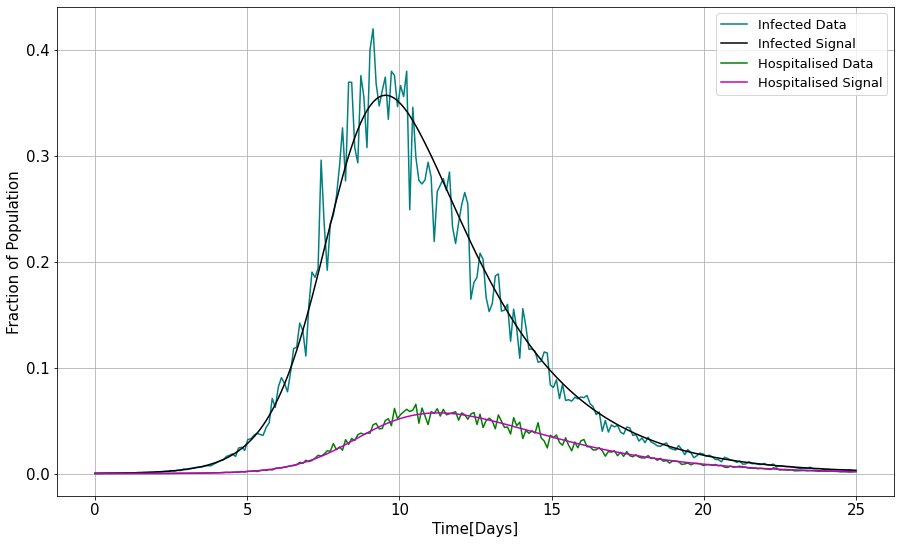

In [11]:

plt.figure(figsize=(15,9))
plt.plot(t,I_data/N,label = 'Infected Data',color='teal')
plt.plot(t,I/N,label = 'Infected Signal',color='black')
plt.plot(t,H_data/N,label = 'Hospitalised Data',color='green')
plt.plot(t,H/N,label = 'Hospitalised Signal',color='m')

plt.xlabel("Time[Days]", fontsize = 15)
plt.ylabel("Fraction of Population", fontsize = 15)
plt.legend(fontsize=13)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

plt.savefig('SIRH')
plt.show()


In [254]:
## Experimental data
#SIHR

## LogLikelihood and gradient of the LogLikelihood functions
def log_likelihood(solve_ivp, sirh_odes, t_span, x_0, theta , t, I_data,  H_data):


    sol = solve_ivp(sirh_odes, t_span , x_0, args = theta , t_eval = t)
    S = sol.y[0]
    I = sol.y[1]
    H = sol.y[2]
    R = sol.y[3]
   
    
    
    logp  = -(0.5*np.sum(np.square((I_data-I)))/(np.std(I_data)**2) + 0.5*np.sum(np.square((H_data-H)))/(np.std(H_data)**2))
    return logp


## Wrapper classes to theano-ize LogLklhood and gradient...
class Loglike(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dscalar]

    def __init__(self, solve_ivp, sirh_odes, t_span,x_0, t, I_data,  EHdata):
        self.I_data = I_data
        self.H_data = H_data
        self.solve_ivp = solve_ivp
        self.sirh_odes_odes = sirh_odes
        self.t_span = t_span
        self.x_0 = x_0
        self.t = t
       

    def perform(self, node, inputs, outputs):
        (theta,) = inputs 
        logp = log_likelihood(self.solve_ivp,self.sirh_odes_odes, self.t_span,self.x_0, theta , self.t, self.I_data,  self.H_data)
        
        outputs[0][0] = np.array(logp)



loglike = Loglike(solve_ivp, sirh_odes, t_span,x_0, t, I_data,  H_data)
with pm.Model() as model:
   
    
  
    
    b = pm.Uniform('b',lower = 0, upper = 5)
    g = pm.Uniform('g', lower = 0, upper = 5)
    ih = pm.Uniform('ih', lower = 0, upper = 5)
    hr = pm.Uniform('hr', lower = 0, upper = 5)
   
    
    theta = tt.as_tensor_variable([b, g, ih, hr,N])
    
    pm.Potential("like", loglike(theta))
    



with model:
    trace = pm.sample(draws = 2000, chains = 10 , tune = 2000, cores  = 1)
    # trace = pm.sample(step=pm.NUTS())
    # idata = pm.sample(return_inferencedata=True)
    print(pm.summary(trace).to_string())

C:\Users\sulai\AppData\Local\Temp/ipykernel_9284/2586544797.py:63: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = 2000, chains = 10 , tune = 2000, cores  = 1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (10 chains in 1 job)
CompoundStep
>Slice: [hr]
>Slice: [ih]
>Slice: [g]
>Slice: [b]


Sampling 10 chains for 2_000 tune and 2_000 draw iterations (20_000 + 20_000 draws total) took 4259 seconds.
The number of effective samples is smaller than 10% for some parameters.


     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
b   1.390  0.026   1.343    1.439      0.001    0.000    1376.0    2960.0   1.01
g   0.293  0.028   0.239    0.344      0.001    0.001     828.0    1235.0   1.01
ih  0.112  0.021   0.077    0.150      0.001    0.001     665.0    1092.0   1.02
hr  0.555  0.113   0.366    0.758      0.005    0.003     626.0     969.0   1.02


In [256]:
b = trace["b"]
g = trace["g"]
ih = trace["ih"]
hr = trace["hr"]


"Set up of Model parameters"
t_span = np.array([0, 25])  # Time limits
t = np.linspace(t_span[0], t_span[1], t_span[1] * 10 )  # Time series
x_0 = np.array([9980, 2, 0, 0])  # Initial conditions for model variables: S, I, R respectively
N = np.sum(x_0)
args = (1.4, 0.3, 0.1, 0.5, N)# arguments for our model parameters: \beta, \gamma, N
"----------------------------------------------------------------------------------------------------------------------"
# data , signal = data_generator(t_span, x_0,args,t)

chi_store = []

for b, g, ih, hr in zip(b, g, ih, hr):
    chi_value = 1
    chi_store.append(chi_value)
    
chains = np.column_stack([ chi_store, trace["b"] ,trace["g"],trace["ih"],trace["hr"] ])
datafile_path = "chain_SIHR"
np.savetxt(datafile_path , chains, fmt=['%f','%f','%f', '%f', '%f'])

In [12]:

"Set up of Model parameters"
t_span = np.array([0, 25])  # Time limits
t = np.linspace(t_span[0], t_span[1], t_span[1] * 10 )  # Time series
x_0 = np.array([9980, 2, 0, 0])  # Initial conditions for model variables: S, I, R respectively
N = np.sum(x_0)
args = (1.391, 0.294, 0.111, 0.55, N)# arguments for our model parameters: \beta, \gamma, N

solo = solve_ivp(sirh_odes, t_span, x_0, args=(args), t_eval=t)

S_min = solo.y[0]
I_min = solo.y[1]
H_min = solo.y[2]
R_min = solo.y[3]

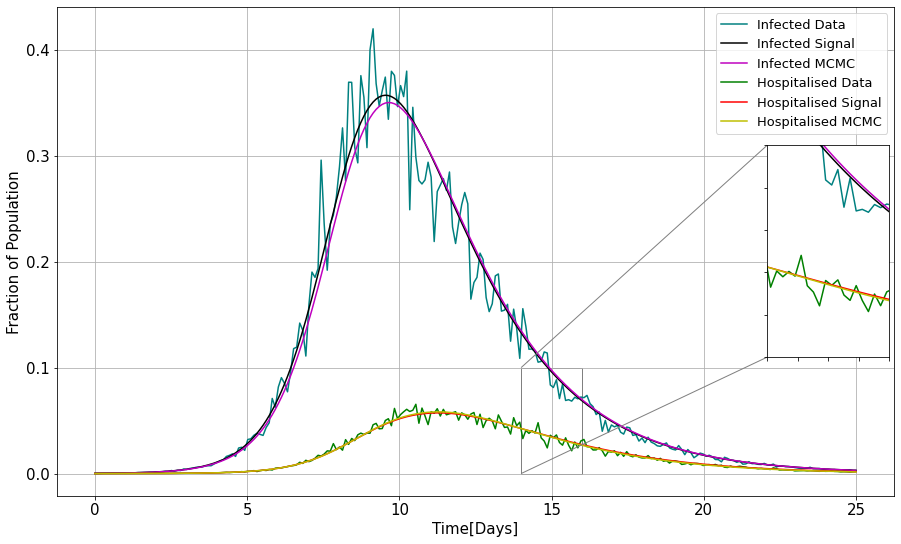

In [32]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

plt.figure(figsize=(15,9))
ax = plt.axes()
ax.plot(t,I_data/N,label = 'Infected Data',color='teal')
ax.plot(t,I/N,label = r'Infected Signal',color='black')
ax.plot(t,I_min/N,label = r'Infected MCMC', color = 'm')
ax.plot(t,H_data/N,label = 'Hospitalised Data',color='g')
ax.plot(t,H/N,label = r'Hospitalised Signal',color= 'r')
ax.plot(t,H_min/N,label = r'Hospitalised MCMC', color = 'y')

plt.xlabel("Time[Days]", fontsize = 15)
plt.ylabel("Fraction of Population", fontsize = 15)
plt.legend(fontsize=13)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

# by trial and error. How can I pass more elegantly the dates as something like
x1 = 14
x2 = 16

# select y-range for zoomed region
y1 = 0
y2 = 0.1

# Make the zoom-in plot:
axins = zoomed_inset_axes(ax, 2, loc=5) # zoom = 2
axins.plot(t,I_data/N,label = 'Infected Data',color='teal')
axins.plot(t,I/N,label = r'Infected Signal, $\beta = 1.4, \gamma = 0.3 $',color='black')
axins.plot(t,I_min/N,label = r'Infected MCMC, $\beta = 1.42 \pm 0.04, \gamma = 0.3 \pm 0.026  $', color = 'm')
axins.plot(t,H_data/N,label = 'Hospitalised Data',color='g')
axins.plot(t,H/N,label = r'Hospitalised Signal',color= 'r')
axins.plot(t,H_min/N,label = r'Hospitalised MCMC', color = 'y')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")

plt.draw()

plt.savefig('MCMC IH')
plt.show()

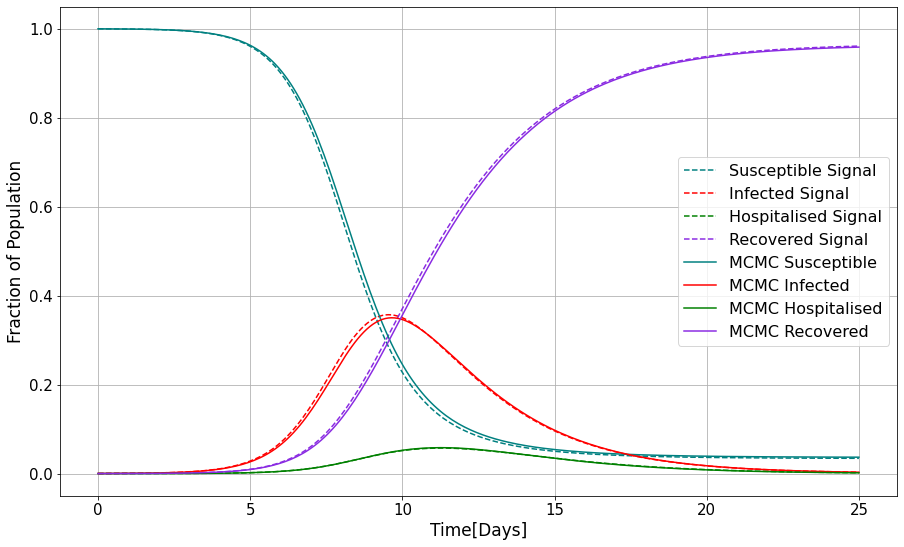

In [31]:
plt.figure(figsize=(15,9))
plt.plot(t,S/N,label = 'Susceptible Signal',color='teal', ls = '--')
plt.plot(t,I/N,label = 'Infected Signal',color='red',ls = '--')
plt.plot(t,H/N,label = 'Hospitalised Signal', color='g',ls = '--')
plt.plot(t,R/N,label = 'Recovered Signal',color='blueviolet',ls = '--')
plt.plot(t,S_min/N,label = 'MCMC Susceptible',color='teal')
plt.plot(t,I_min/N,label = 'MCMC Infected', color='red')
plt.plot(t,H_min/N,label = 'MCMC Hospitalised', color='g')
plt.plot(t,R_min/N,label = 'MCMC Recovered', color='blueviolet')
# plt.plot(t,S/N + I/N + R/N, label = "Total Population", color = 'black', ls = '--' )
plt.xlabel("Time[Days]", fontsize = 17)
plt.ylabel("Fraction of Population", fontsize = 17)
plt.legend(fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.savefig('SIHR MCMC')
plt.show()